### Import Dependencies

In [15]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
torch.cuda.is_available()

True

### Import Datasets and Get Classes

In [17]:
for dirpath, dirnames, filenames in os.walk("Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

bean_class = len(os.listdir("Dataset/train"))

dataset_dir = pathlib.Path("Dataset/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

There are 3 directories and 0 images in Dataset
There are 4 directories and 0 images in Dataset\test
There are 0 directories and 400 images in Dataset\test\Dark
There are 0 directories and 400 images in Dataset\test\Green
There are 0 directories and 400 images in Dataset\test\Light
There are 0 directories and 400 images in Dataset\test\Medium
There are 4 directories and 0 images in Dataset\train
There are 0 directories and 1200 images in Dataset\train\Dark
There are 0 directories and 1200 images in Dataset\train\Green
There are 0 directories and 1200 images in Dataset\train\Light
There are 0 directories and 1200 images in Dataset\train\Medium
There are 4 directories and 0 images in Dataset\val
There are 0 directories and 400 images in Dataset\val\Dark
There are 0 directories and 400 images in Dataset\val\Green
There are 0 directories and 400 images in Dataset\val\Light
There are 0 directories and 400 images in Dataset\val\Medium
['Dark' 'Green' 'Light' 'Medium']


### Data Preprocessing

##### Call the dataset

In [18]:
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

image_dataset = datasets.ImageFolder(root='Dataset/train/',transform=resize_transform)

##### Show image example in each class

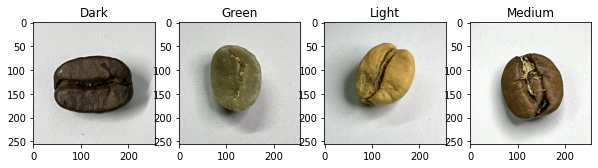

In [19]:
# Define the classes of your dataset
classes = image_dataset.classes

# Create a figure with subplots for each class
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# Loop through each class and plot the first image
for i, cls in enumerate(classes):
    # Get the indices of the images for this class
    indices = [j for j, (x, y) in enumerate(image_dataset) if y == i]
    # Get the first image for this class
    img = image_dataset[indices[0]][0]
    img = img.resize((256,256))
    # Plot the image on the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(cls)

plt.show()

##### Create image preprocessing

In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

##### Show image transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


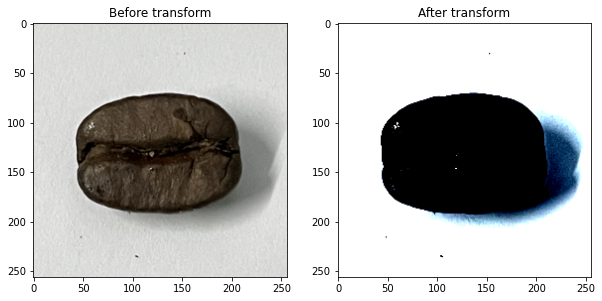

In [21]:
example_image, _ = image_dataset[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(example_image)
ax[0].set_title('Before transform')
transformed_image = transform(example_image)
ax[1].imshow(transformed_image.permute(1, 2, 0))
ax[1].set_title('After transform')
plt.show()

### ResNet50 Model Building

In [22]:
num_classes = 4
batch_size = 64
num_epochs = 64
learning_rate = 0.0001

##### Apply preprocessing to transform the dataset

In [23]:
train_set = datasets.ImageFolder(root='Dataset/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = datasets.ImageFolder(root='Dataset/val/', transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = datasets.ImageFolder(root='Dataset/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

##### Load pre-trained ResNet50 model

In [24]:
resnet50 = models.resnet50(pretrained=True)

In [25]:
# Freeze all layers in the pre-trained model
for param in resnet50.parameters():
    param.requires_grad = False

In [26]:
# Replace the last fully connected layer with a new one
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

##### Define loss function and optimizer

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Train and Validate Model

##### Train the model

In [28]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Iterate over the validation dataset in batches
train_predictions = np.array([])
train_ground_truths = np.array([])

for epoch in range(num_epochs):
    # Training
    resnet50.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    train_losses.append(train_loss/train_total)
    train_accs.append(train_correct/train_total)
    
    # Validation
    resnet50.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = resnet50(images)
            loss = criterion(outputs, labels)

            train_predictions = np.concatenate((train_predictions, predicted.cpu().numpy()))
            train_ground_truths = np.concatenate((train_ground_truths, labels.cpu().numpy()))

            
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        # remove the extra predictions
        if len(train_predictions) > len(train_ground_truths):
            train_predictions = train_predictions[:len(train_ground_truths)]

    # Convert predictions and true labels to numpy arrays
    train_predictions = np.array(train_predictions)
    train_ground_truths = np.array(train_ground_truths)
    
    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total)
    
    # Print epoch statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1]))

Epoch [1/64], Train Loss: 1.1329, Train Acc: 0.7231, Val Loss: 0.9041, Val Acc: 0.9006
Epoch [2/64], Train Loss: 0.7814, Train Acc: 0.9202, Val Loss: 0.6522, Val Acc: 0.9575
Epoch [3/64], Train Loss: 0.5828, Train Acc: 0.9540, Val Loss: 0.4977, Val Acc: 0.9688
Epoch [4/64], Train Loss: 0.4678, Train Acc: 0.9567, Val Loss: 0.4128, Val Acc: 0.9663
Epoch [5/64], Train Loss: 0.3953, Train Acc: 0.9635, Val Loss: 0.3533, Val Acc: 0.9656
Epoch [6/64], Train Loss: 0.3407, Train Acc: 0.9631, Val Loss: 0.3031, Val Acc: 0.9688
Epoch [7/64], Train Loss: 0.3026, Train Acc: 0.9650, Val Loss: 0.2671, Val Acc: 0.9719
Epoch [8/64], Train Loss: 0.2708, Train Acc: 0.9685, Val Loss: 0.2414, Val Acc: 0.9769
Epoch [9/64], Train Loss: 0.2508, Train Acc: 0.9650, Val Loss: 0.2180, Val Acc: 0.9762
Epoch [10/64], Train Loss: 0.2281, Train Acc: 0.9679, Val Loss: 0.2035, Val Acc: 0.9744
Epoch [11/64], Train Loss: 0.2104, Train Acc: 0.9698, Val Loss: 0.1896, Val Acc: 0.9750
Epoch [12/64], Train Loss: 0.1977, Train 

##### Plot losses and accuracy

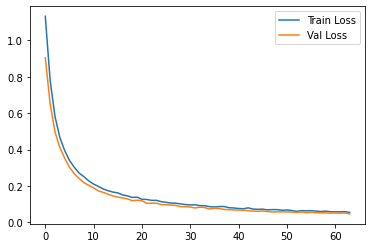

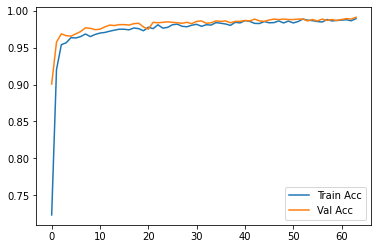

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

##### Calculate the confusion matrix

<Axes: >

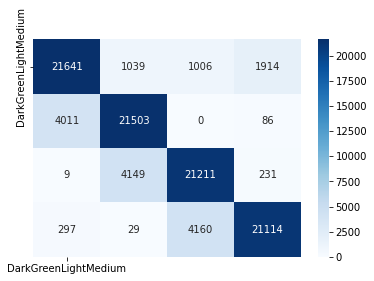

In [30]:
cm = confusion_matrix(train_ground_truths, train_predictions)
labels_category = ['Dark' 'Green' 'Light' 'Medium']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

### Testing Model

##### Set to evaluation mode

In [31]:
# Set the model to evaluation mode
resnet50.eval()

# Keep track of the validation loss and accuracy
test_loss = 0.0
test_correct = 0
test_total = 0

##### Test the model

In [32]:
# Iterate over the validation dataset in batches
test_predictions = []
test_ground_truths = []

for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    # Forward pass
    outputs = resnet50(images)
    loss = criterion(outputs, labels)

    # Update the validation loss
    test_loss += loss.item() * labels.size(0)

    test_predictions.extend(predicted.cpu().numpy())
    test_ground_truths.extend(labels.cpu().numpy())

    # Update the testing accuracy
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

# Compute the average testing loss and accuracy
test_loss /= len(test_set)
test_accuracy = 100 * test_correct / test_total

# Print the testing loss and accuracy
print(f'Testing loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%')

Testing loss: 0.0538, accuracy: 98.69%


##### Calculate the confusion matrix

<Axes: >

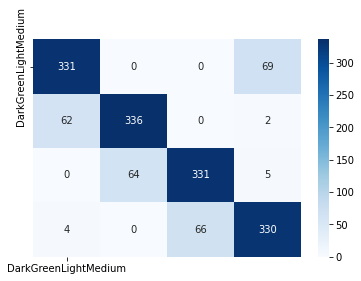

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(test_ground_truths, test_predictions)
labels_category = ['Dark' 'Green' 'Light' 'Medium']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)